#### Script for optimization of a single topology

In [17]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward,MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

### Parametrization

#### 1) mechanism configuration

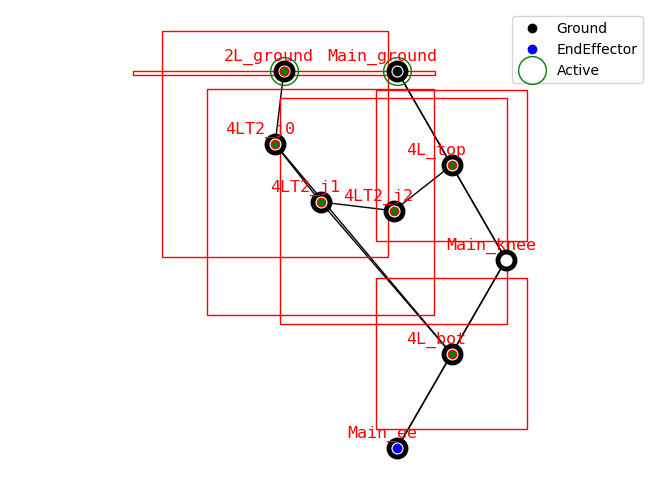

In [18]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[4]

actuator = TMotor_AK10_9()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

In [19]:
# 1) trajectories
workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.3, -0.95], 0.3, 0.6, 30, 60))
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.2, -0.9], step_height=0.2, step_width=0.4, n_points=50))
central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.9, 0.2, 0, 50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
min_velocity = MinManipulabilityReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

min_force = MinForceReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error')
#soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step, central_vertical])


# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(central_vertical, 1)
reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(min_velocity, 0, 1)
reward_manager.add_reward(heavy_lifting, 1, 1)
reward_manager.add_reward(min_force,1,1)



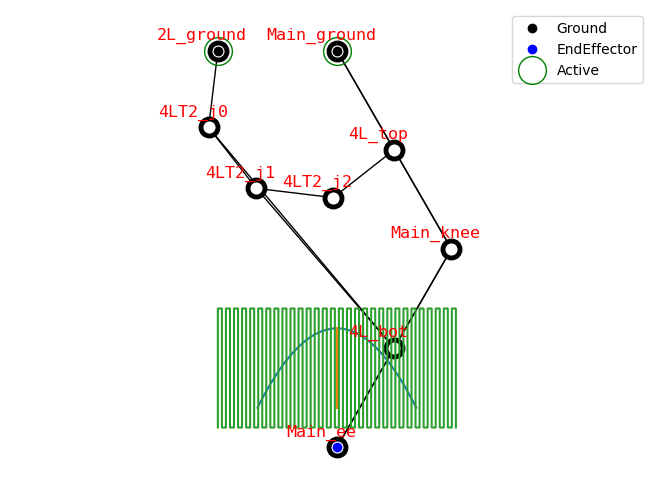

In [20]:
draw_joint_point(graph)

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()


#### Calculate rewards for initial graph.

In [21]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

constrain_error,_ = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
print(constrain_error)



[0.14010679]


In [22]:
if constrain_error == 0:
    total_reward, partial_rewards = reward_manager.calculate_total(fixed_robot=fixed_robot, free_robot=free_robot, motor=actuator)

    print(total_reward)
    print(partial_rewards)

In [23]:
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)


In [24]:
population_size = 32
n_generations = 60

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.

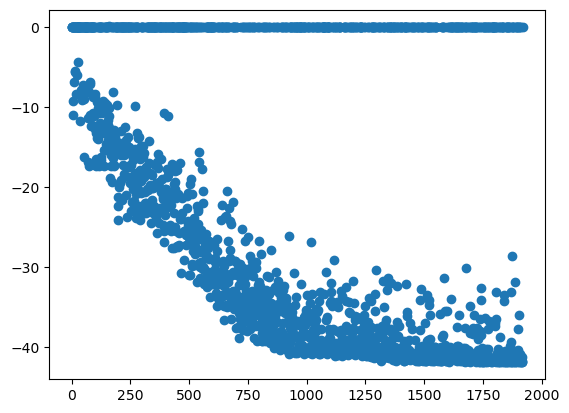

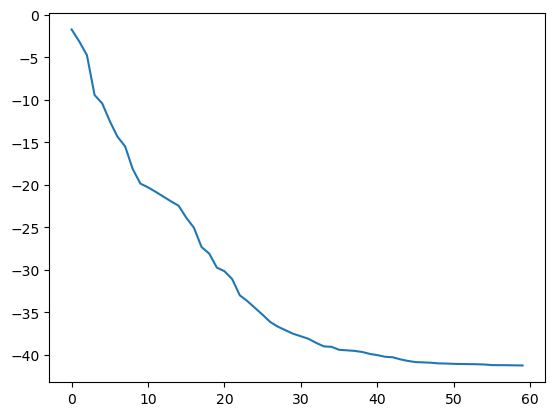

In [ ]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [ ]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 0.10088037343847649


The minimum result in optimization task: [-41.92309285]


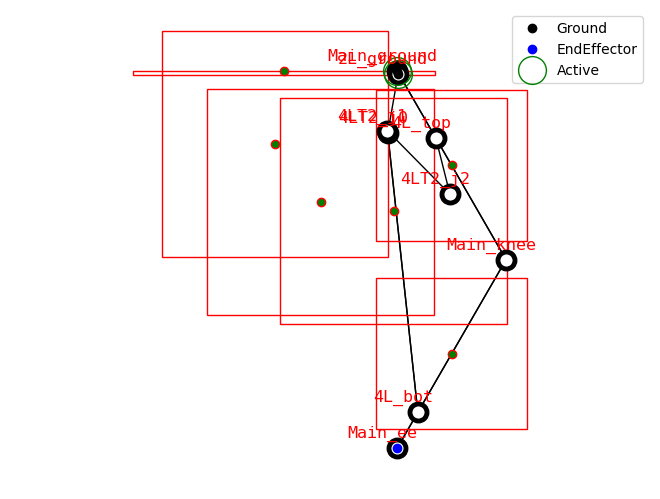

In [ ]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
visualize_constrains(problem.graph, constrain_dict)


In [ ]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[ 0.        , 24.03368728],
       [ 1.        , 17.88940557]])

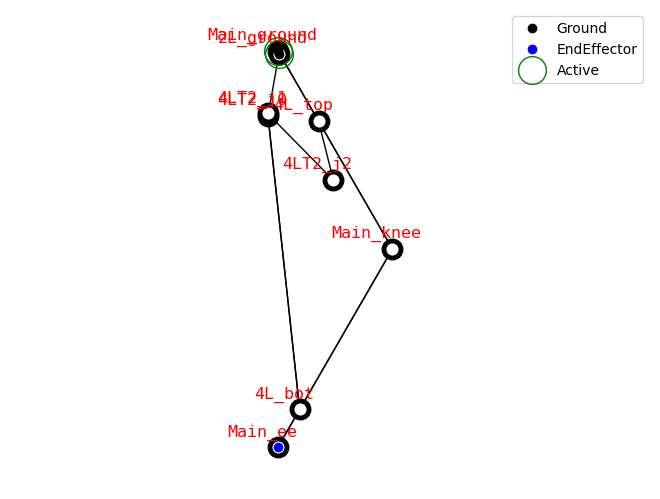

In [ ]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

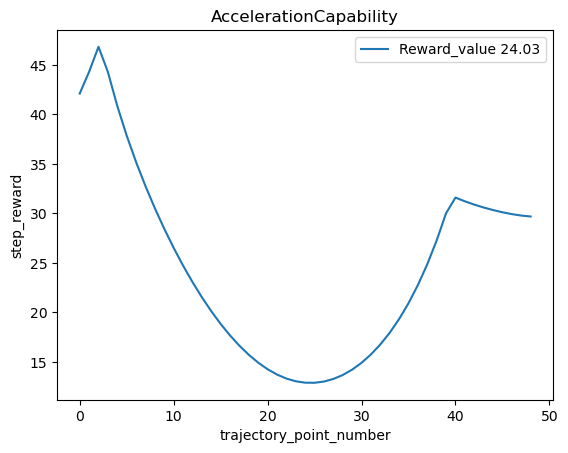

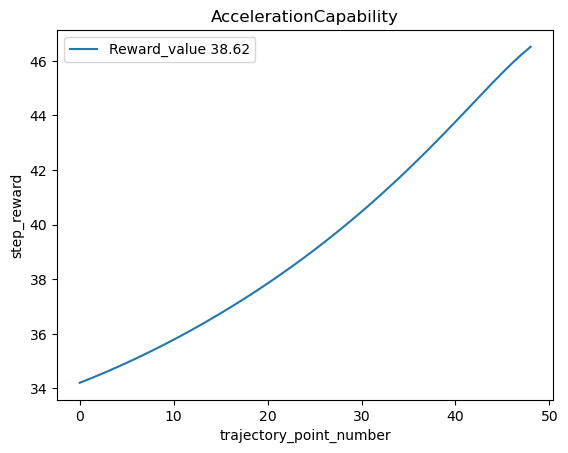

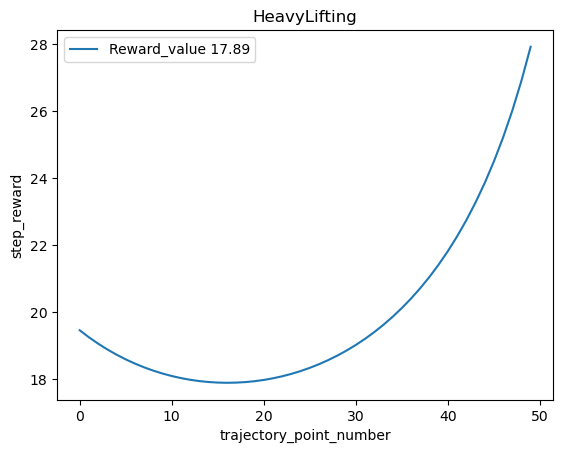

In [ ]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

reward_decomposition = best_reward_decomposition[1]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

reward_decomposition = best_reward_decomposition[1]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLifting')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

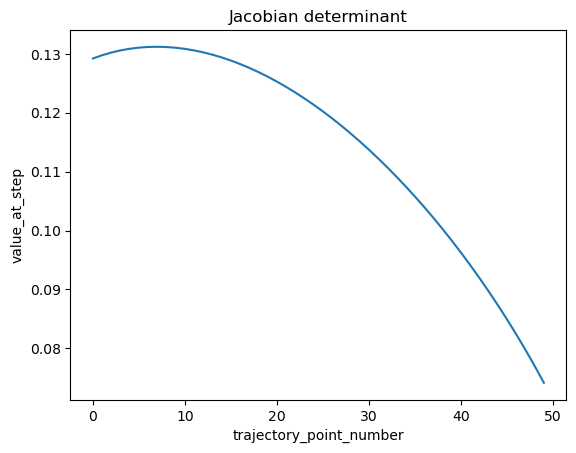

In [ ]:
plt.plot(point_criteria_vector["MANIP"])
plt.xlabel('trajectory_point_number')
plt.ylabel('value_at_step')
plt.title('Jacobian determinant')
plt.show()

In [ ]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
calculate_quasi_static_simdata(free_robot, fixed_robot,'EE', trajectory, viz=viz)
pass

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


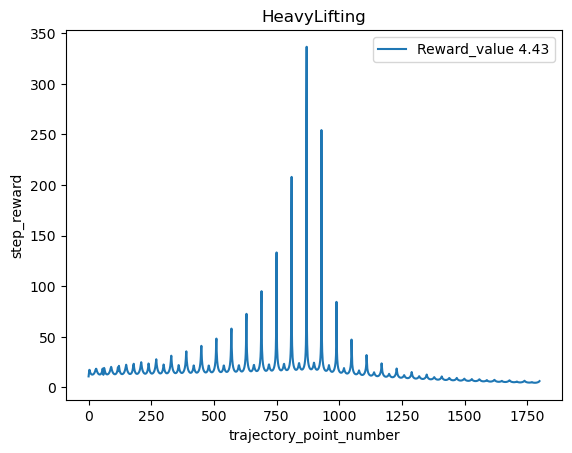

1800


ValueError: array split does not result in an equal division

In [ ]:
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, workspace_trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLifting')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

print(len(reward_vector))
reward_vector=np.array(np.split(reward_vector, 51))
for i, _ in enumerate(reward_vector):
    if not i%2:
        reward_vector[i] = np.flip(reward_vector[i])


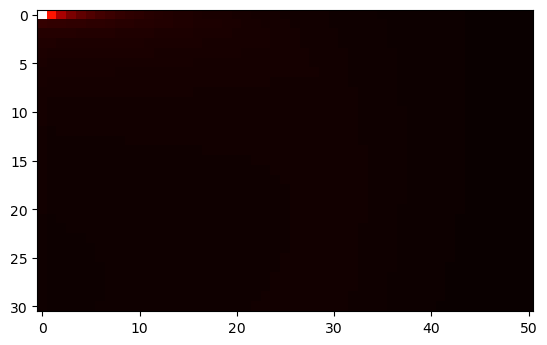

In [ ]:
reward_vector = reward_vector.T
plt.imshow(reward_vector, cmap='hot', interpolation='nearest')
plt.show()


In [ ]:
reward_vector.shape

(51, 31)

<Axes: >

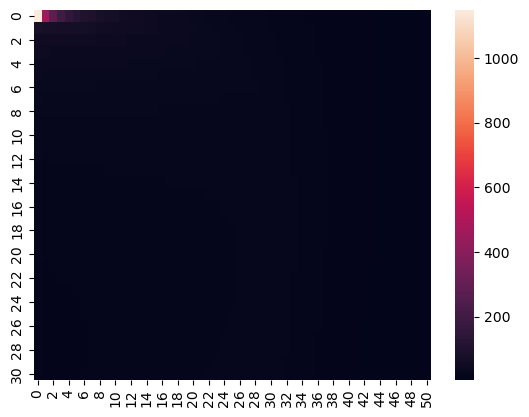

In [ ]:
import seaborn as sns

sns.heatmap(reward_vector)